In [1]:
import numpy as np

from experiment_framework.empirical_bootstrap import EmpiricalBootstrap, SampleGenerator
from experiment_framework.asymptotic_analysis import construct_bootstrap, transform_n_to_k_for_knn, asymptotic_curve
from notebook_context import *
from math import sqrt, log

In [2]:
def hoeffding_t(n, p):
    t = sqrt(log((1-p)/2)/(-2*n))
    t_one_sided = sqrt(log(1-p)/(-2*n))
    return t, t_one_sided


def hoeffding_bounds(data, p=0.99):
    n = data.size
    t, t_one_sided = hoeffding_t(n, p)
    mu = np.mean(data)
    return EmpiricalBootstrap._RTV(lb_two_sided=mu-t,
                                   ub_two_sided=mu+t,
                                   lb_one_sided=mu-t,
                                   ub_one_sided=mu+t
                                  )

In [372]:
hoeffding_t(2**14, .9)[0]

0.00956151105734694

m_hat = 0.65125338630058


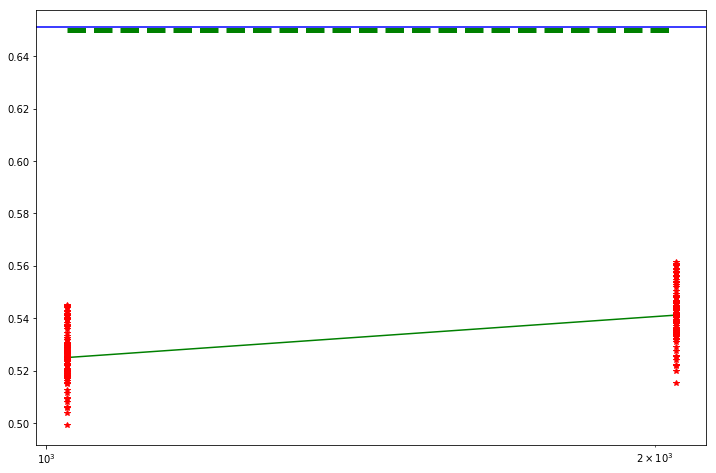

In [3]:
N = np.array([2**i for i in range(10,12)])
m = 0.65
c = 0.5
d = 3
e = 1/(d+2)

p_outlier_noise = 0.01

def model(n):
    return m - c*1/(n**e)

def noise(n):
    if np.random.rand() < p_outlier_noise:
        return 0.001 * np.random.randn()+0.02*np.sign(np.random.rand()-0.5)
    return 0.01 * np.random.randn()

def noisy_model(n):
    return model(n) + noise(n)

plt.figure(figsize=(12,8))

plt.semilogx(N, model(N), '-*g')
plt.semilogx(N, np.ones_like(N)*m, '--g', linewidth=5)


def gen_data(n_trials=100):
    X = N
    y = noisy_model(N)
    for _ in range(n_trials-1):
        X = np.vstack((X, N))
        y = np.vstack((y, noisy_model(N)))
    X = X.astype(np.double)  # for transformation to Ks

    return X, y

X, y = gen_data(100)
_ = plt.semilogx(X, y, '*r')

Ks = transform_n_to_k_for_knn(X, 'gyorfi', d=3)
m_hat, C_hat = asymptotic_curve(Ks.reshape(Ks.size), y.reshape(y.size))
plt.axhline(m_hat, color='b')
print('m_hat = {}'.format(m_hat))

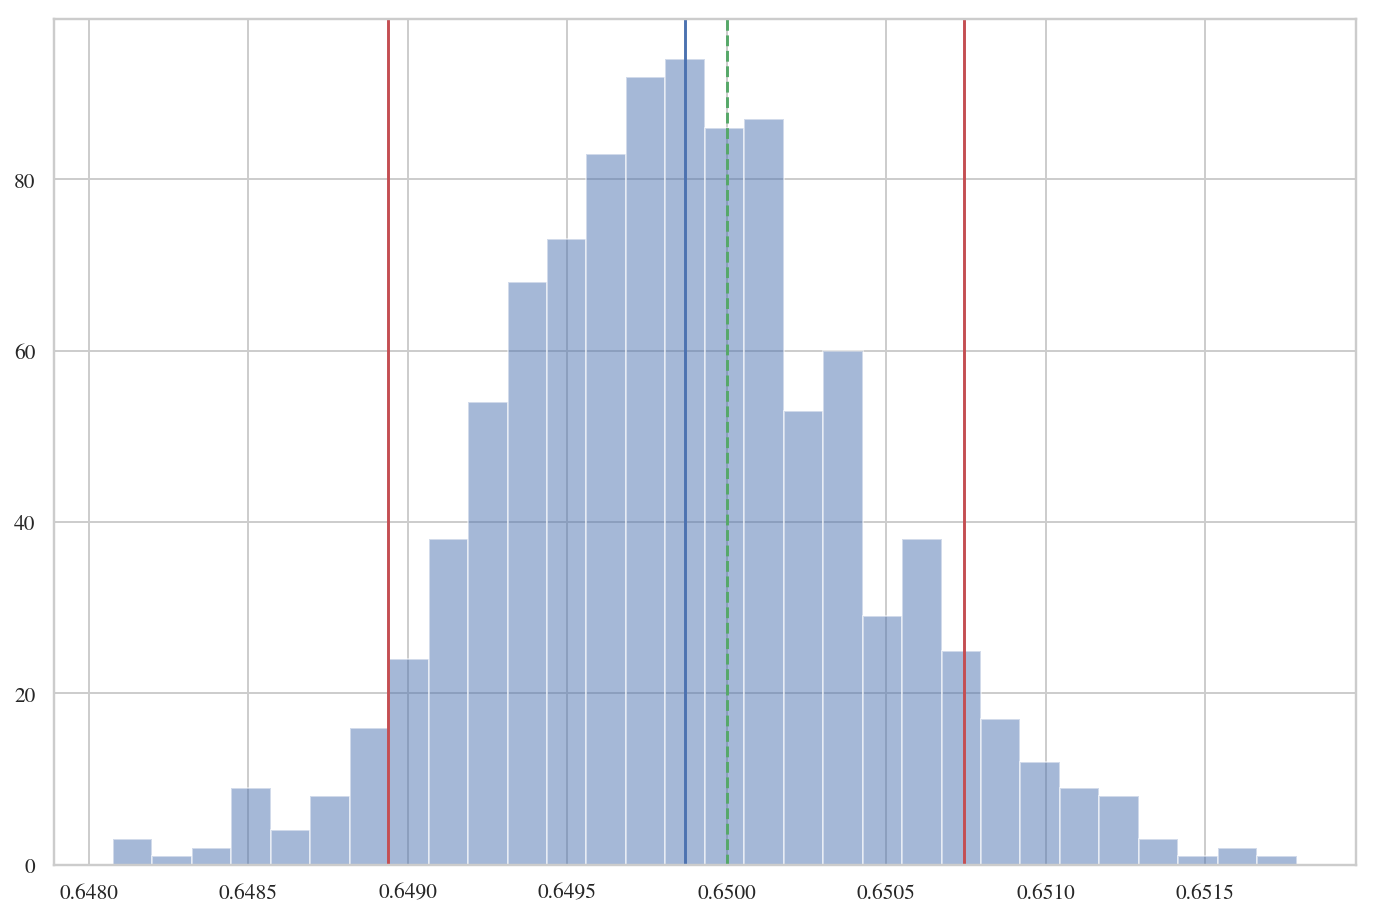

In [39]:
X, y = gen_data(300)
p = 0.9

# X = X.reshape(X.size)
# y = y.reshape(y.size)
EB = construct_bootstrap(X=X, d=3, fit_model='gyorfi', classifier_accuracies=y)
sampled_asymptotes = EB.bootstrap_confidence_bounds(p, n_samples=1000)
plt.figure(figsize=(12,8))
_ = plt.hist(EB.generated_samples, alpha=0.5, bins=30)
plt.axvline(sampled_asymptotes.lb_two_sided, color='r')
plt.axvline(sampled_asymptotes.ub_two_sided, color='r')
plt.axvline(m, color='g', linestyle='--')
plt.axvline(EB.sample_generator.sample_mean, color='b')

# HB = hoeffding_bounds(EB.sample_generator.data, p)
# plt.axvline(HB.lb_two_sided, color='r', linestyle='--')
# plt.axvline(HB.ub_two_sided, color='r', linestyle='--')

In [344]:
results = []
from multiprocessing import Pool

In [349]:
def try_bootstrap(*args):
    np.random.seed()
    X, y = gen_data(30)
    EB = construct_bootstrap(X=X, d=3, fit_model='gyorfi', classifier_accuracies=y)
    sampled_asymptotes = EB.bootstrap_confidence_bounds(0.99, n_samples=1000)
    if sampled_asymptotes.lb_two_sided <= m <= sampled_asymptotes.ub_two_sided:
        return 1
    else:
        return 0


with Pool() as pool:
    results.extend(pool.map(try_bootstrap, range(1000)))
n_success = sum(results)
n_trials = len(results)
print(n_success/n_trials)
print(n_trials)

0.9828
5000


# Try bootstrap at each `training_set_size`

In [4]:
from collections import defaultdict
from math import ceil

import itertools

In [12]:
accuracies = {tss:[] for tss in N}
min_samples = 3
convergence_ratio = 1e-4

def converged(accuracy_list):
    std0 = np.std(accuracy_list[0:2])
    std1 = np.std(accuracy_list[0:3])
    stdn1 = np.std(accuracy_list[0:-1])
    stdn = np.std(accuracy_list)
    d0 = abs(std0 - std1)
    dn = abs(stdn - stdn1)
#     print(f'd0={d0} dn={dn}')
    return dn/d0 < convergence_ratio

for tss in accuracies.keys():
    while len(accuracies[tss]) < min_samples or not converged(accuracies[tss]):
        accuracies[tss].append(noisy_model(tss))
        
print([(k, len(v)) for k,v in accuracies.items()])

[(1024, 275), (2048, 451)]


p_intermediate = 9.950e-01


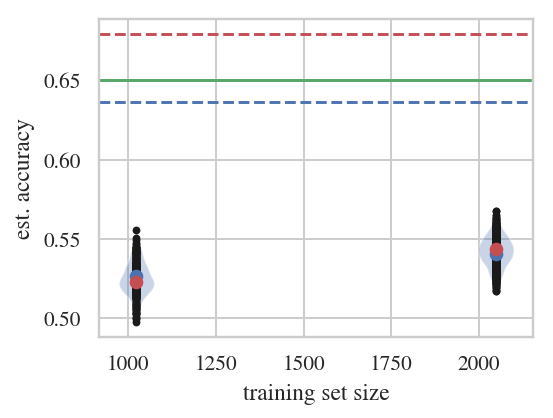

In [21]:
p = 0.99
n_tss = len(accuracies.keys())
p_intermediate = p ** (1/n_tss)
print('p_intermediate = {:.3e}'.format(p_intermediate))

configure_plotting_for_publication()
plt.figure(figsize=(4,3))


_ = plt.violinplot(
    accuracies.values(),
    positions=list(accuracies.keys()),
    widths=100,
    showextrema=False
)
bootstraps = {tss: EmpiricalBootstrap(SampleGenerator(data=acc)).\
              bootstrap_confidence_bounds(p_intermediate, n_samples=1000)
             for (tss, acc) in accuracies.items()}
accuracy_combinations = list(itertools.product(*[
    [bs.lb_two_sided, bs.ub_two_sided]
    for tss, bs in bootstraps.items()
]))

Ks = transform_n_to_k_for_knn(N, 'gyorfi', d=d)
m_max = -float('inf')
m_min = float('inf')
i_min = None
i_max = None
for (i, accuracy_combination) in enumerate(accuracy_combinations):
    m_hat, C_hat = asymptotic_curve(Ks.reshape(Ks.size), accuracy_combination)
    if m_hat < m_min:
        m_min = m_hat
        i_min = i
    if m_hat > m_max:
        m_max = m_hat
        i_max = i

for x, y in accuracies.items():
    y= np.array(y)
    plt.scatter(np.ones_like(y)*x, y, marker='.', color='k')

plt.xlabel("training set size")
plt.ylabel("est. accuracy")


plt.scatter(N, accuracy_combinations[i_min], color='b')
plt.scatter(N, accuracy_combinations[i_max], color='r')

plt.axhline(m_max, linestyle='--', color='r')
plt.axhline(m_min, linestyle='--', color='b')
plt.axhline(m, linestyle='-', color='g')